# FOMC Case Study: Examining Financial Market Reactions to Federal Reserve Meetings

This notebook applies Principal Component Analysis (PCA) and Independent Component Analysis (ICA) to analyze financial market reactions to Federal Open Market Committee (FOMC) meetings. We examine how the S&P 500 index moves around FOMC meeting dates and identify underlying patterns in these movements. These are meeting date, not minutes dates, and to note is that the market does not observe the meetings themselves.

## 1. Setup and Data Import

First, we'll import the necessary libraries and configure warning settings for cleaner output.

In [63]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

np.random.seed(9)

## 2. Data Loading and Initial Processing

Now we'll load the S&P 500 index data and FOMC meeting data, then prepare it for analysis by calculating log returns for the S&P 500.

In [64]:
spy_df = pd.read_csv('../data/sp500_raw_index_1976-01-01_to_2023-12-31_1D.csv')
spy_df['Date'] = pd.to_datetime(spy_df['Date'])
spy_df['Log Return'] = np.log(spy_df['Adj Close']).diff()
spy_df.set_index('Date', inplace=True)
df = pd.read_csv('../data/meeting_time_series.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date
0,1976-03-29
1,1976-04-20
2,1976-05-18
3,1976-06-22
4,1976-07-20


## 3. Event Study Window Construction

We'll now create an event study window around each FOMC meeting date. This involves:
1. Defining a window from 45 days before to 45 days after each meeting
2. Calculating log returns for each day in this window
3. Computing cumulative returns throughout the window

In [65]:
start_window = -45
return_window = 45
for i in range(start_window, return_window + 1):
    spy_df[f'Log Return t={i}'] = spy_df['Log Return'].shift(-i)
spy_df = spy_df.dropna()

for t in range(start_window, return_window + 1):
    spy_df[f'Cumulative Log Return {t}'] = spy_df.loc[:, f'Log Return t={start_window}':f'Log Return t={t}'].sum(axis=1)

for i in range(start_window, return_window + 1):
    spy_df = spy_df.drop(columns=[f'Log Return t={i}'])

## 4. Merging FOMC Meetings with Market Returns

Now we'll merge the FOMC meeting data with the S&P 500 returns, aligning each meeting with the appropriate market data. We also demean the cumulative returns to focus on abnormal returns around meeting events. This removes any innovation affect, since the market generally increases on average.

In [66]:
featured_events = pd.merge_asof(df, spy_df, on='Date', direction='backward', suffixes=('', '_y'), allow_exact_matches=False)

for t in range(start_window, return_window + 1):
    featured_events[f'Cumulative Log Return {t}'] = (featured_events[f'Cumulative Log Return {t}'] - featured_events[f'Cumulative Log Return {t}'].expanding().mean())

featured_events = featured_events.dropna()
spts = [featured_events for featured_events in featured_events.columns if 'Cumulative Log Return' in featured_events]

featured_events = featured_events.rename(columns={col: col.replace('Cumulative Log Return ', '') for col in spts})
spts = [n.replace('Cumulative Log Return ', '') for n in spts]

featured_events.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Log Return,-45,-44,...,36,37,38,39,40,41,42,43,44,45
0,1976-03-29,0.0,103.650002,102.199997,102.849998,102.849998,18510000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1976-04-20,0.0,101.830002,100.320000,101.440002,101.440002,16500000,0.007620,-0.001568,-0.010401,...,-0.025314,-0.020784,-0.018036,-0.009318,-0.002659,-0.000207,0.008329,0.008851,0.007342,0.005093
2,1976-05-18,0.0,101.709999,100.410004,101.089996,101.089996,14720000,-0.002470,-0.004370,-0.013434,...,0.010227,0.014115,0.012719,0.010312,0.019727,0.013022,0.005034,0.001929,-0.006064,-0.001722
3,1976-06-22,0.0,104.730003,103.180000,104.279999,104.279999,18930000,0.004999,0.007030,0.013871,...,0.019969,0.016858,0.009483,0.010602,0.018332,0.016911,0.006197,-0.000768,-0.005662,-0.008222
4,1976-07-20,0.0,105.320000,103.839996,104.290001,104.290001,18200000,-0.003733,-0.002005,-0.009075,...,0.003329,-0.004515,-0.008733,-0.011974,-0.011309,-0.008229,0.000523,0.009914,0.009586,0.024253


## 5. Principal Component Analysis (PCA)

Here we apply PCA to the market returns around FOMC meetings to identify the dominant patterns of market behavior. The top principal components represent the most common market reaction patterns.

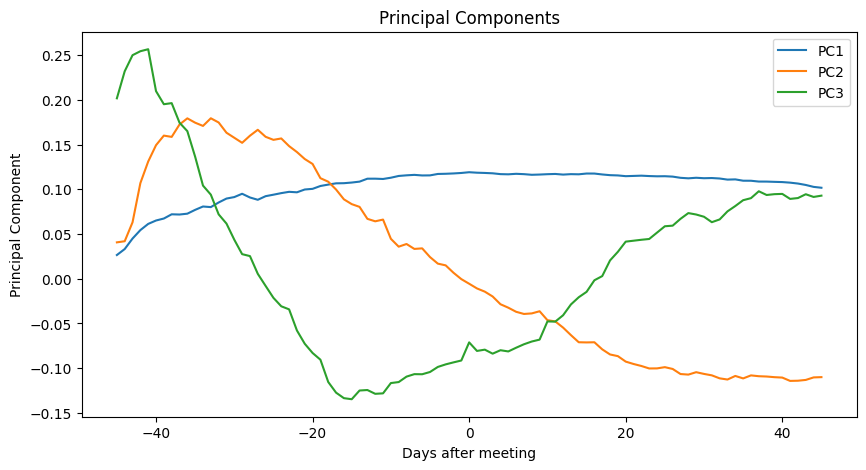

In [67]:
# DO PCA on the spts
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

scaler = StandardScaler()
pca = PCA()

pipe = Pipeline([('scaler', scaler), ('pca', pca)])
pipe.fit(featured_events[spts])

# PLot the principal components. Subtract 45 from x-axis to center the plot around 0
n_days = len(pipe.named_steps['pca'].components_[0])
x_values = np.arange(n_days) - 45

pcs = pipe.transform(featured_events[spts])

featured_events['PC1'] = pcs[:, 0]
featured_events['PC2'] = pcs[:, 1]
featured_events['PC3'] = pcs[:, 2]

plt.figure(figsize=(10, 5))
plt.plot(x_values, pipe.named_steps['pca'].components_[:3].T)
plt.title('Principal Components')
plt.xlabel('Days after meeting')
plt.ylabel('Principal Component')
plt.legend(['PC1', 'PC2', 'PC3'])
plt.show()

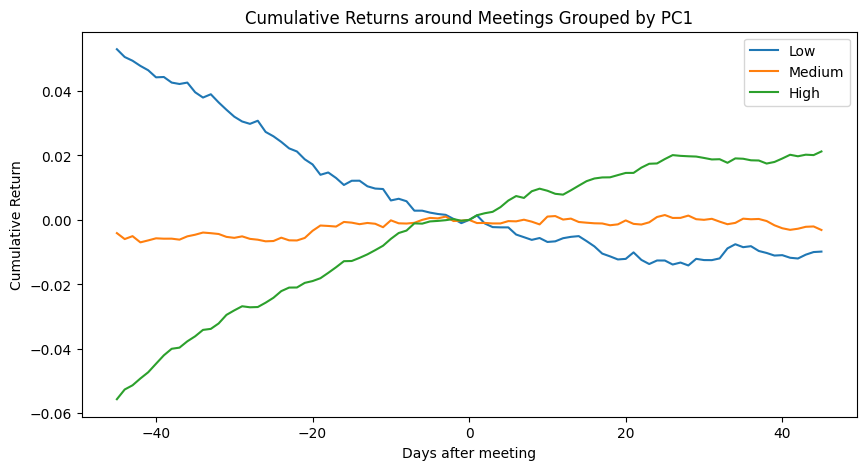

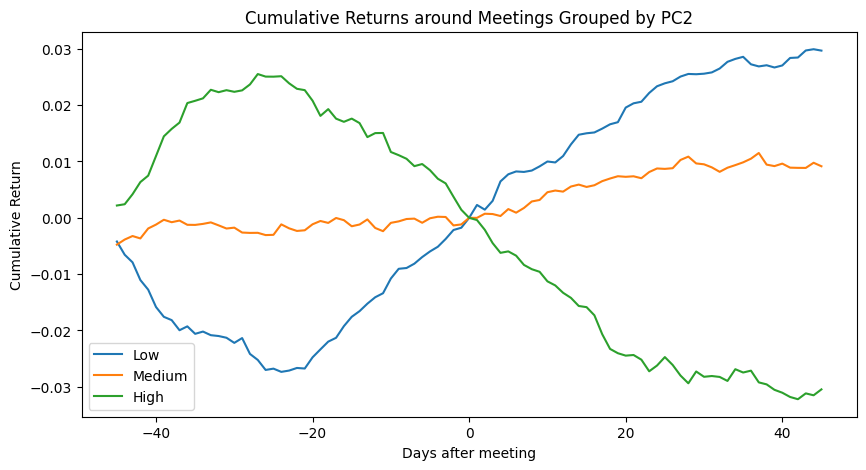

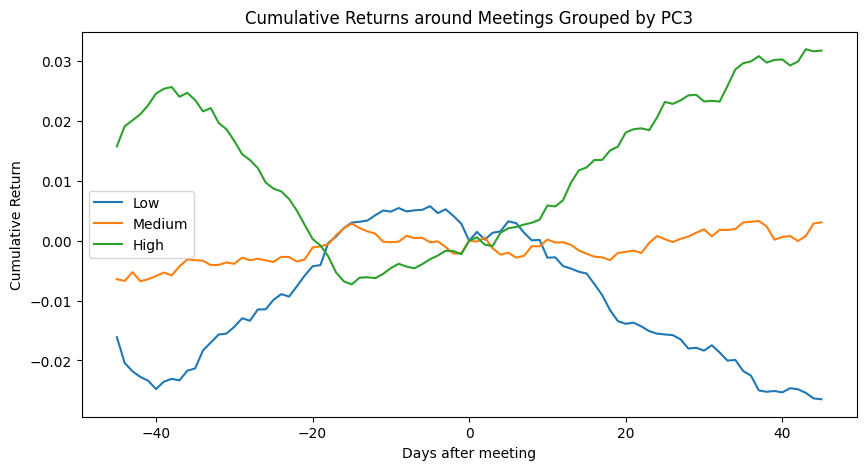

In [68]:
def plot_cumulative_returns(featured_events, return_col, pc_col, n_bins=3 , title=None, xlabel='Days after meeting', ylabel='Cumulative Return'):
    
    if not title:
        title= f'Cumulative Returns by {pc_col}'

    # Create bins for the PC values
    featured_events['PC Bin'] = pd.qcut(featured_events[pc_col], n_bins, labels=False)

    # Calculate the mean cumulative returns for each bin
    mean_returns = featured_events.groupby('PC Bin')[return_col].mean()

    # Subtract the return at t=0 to align the average path to the meeting date
    t0_col = return_col[len(return_col) // 2]  # assuming return_col is centered and t=0 is in the middle
    mean_returns = mean_returns.subtract(mean_returns[t0_col], axis=0)

    # Plot the mean cumulative returns for each bin
    plt.figure(figsize=(10, 5))
    for i in range(n_bins):
        if n_bins == 3:
            if i == 0:
                label = 'Low'
            elif i == 1:
                label = 'Medium'
            else:
                label = 'High'
        else:
            label = f'Bin {i}'
        plt.plot(x_values, mean_returns.iloc[i], label=label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

# Example calls
plot_cumulative_returns(featured_events, spts, 'PC1', title='Cumulative Returns around Meetings Grouped by PC1')
plot_cumulative_returns(featured_events, spts, 'PC2', title='Cumulative Returns around Meetings Grouped by PC2')
plot_cumulative_returns(featured_events, spts, 'PC3', title='Cumulative Returns around Meetings Grouped by PC3')

## 6. Independent Component Analysis (ICA)

Now we apply ICA to identify statistically independent patterns in market reactions. While PCA focuses on variance, ICA tries to find truly independent sources of variation that might represent distinct market behaviors.

/Users/amanrana/Documents/Projects/Event_Studies_w_CA/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but FastICA was fitted without feature names
  warnings.warn(
/Users/amanrana/Documents/Projects/Event_Studies_w_CA/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but FastICA was fitted without feature names
  warnings.warn(
/Users/amanrana/Documents/Projects/Event_Studies_w_CA/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but FastICA was fitted without feature names
  warnings.warn(


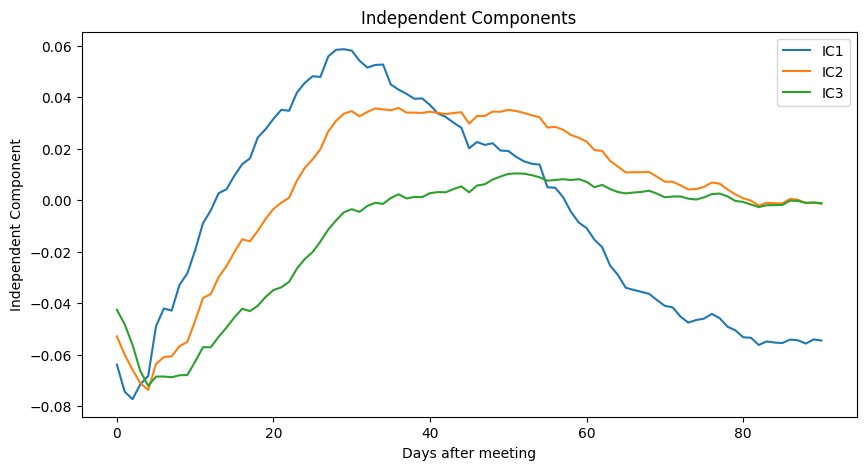

In [69]:
# Do ICA on the spts
from sklearn.decomposition import FastICA
from sklearn.pipeline import make_pipeline
ica = FastICA(n_components=3)
ica_pipe = make_pipeline(StandardScaler(), ica)
ica_pipe.fit(featured_events[spts])

featured_events['IC1'] = ica_pipe.named_steps['fastica'].transform(featured_events[spts])[:, 0]
featured_events['IC2'] = ica_pipe.named_steps['fastica'].transform(featured_events[spts])[:, 1]
featured_events['IC3'] = ica_pipe.named_steps['fastica'].transform(featured_events[spts])[:, 2]

# PLot the principal components. Subtract 45 from x-axis to center the plot around 0
n_days = len(ica_pipe.named_steps['fastica'].components_[0])
x_values = np.arange(n_days) - 45

# plot the top 3 components
plt.figure(figsize=(10, 5))
plt.plot(ica_pipe.named_steps['fastica'].components_[:3].T)
plt.title('Independent Components')
plt.xlabel('Days after meeting')
plt.ylabel('Independent Component')
plt.legend(['IC1', 'IC2', 'IC3'])
plt.show()

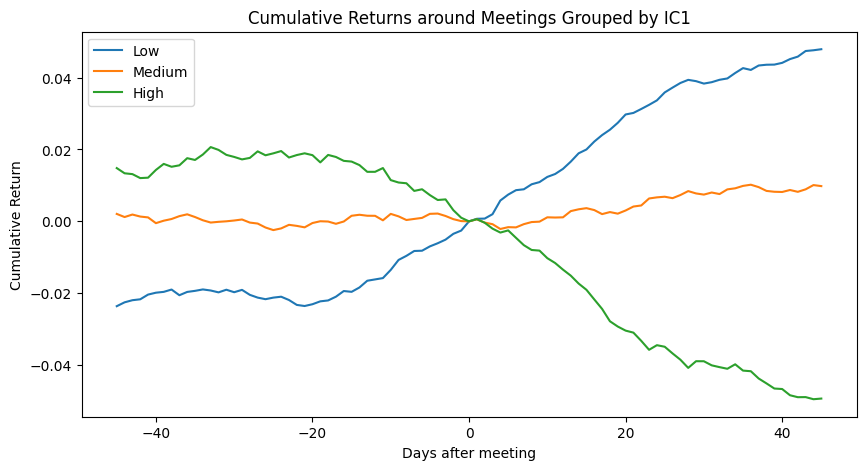

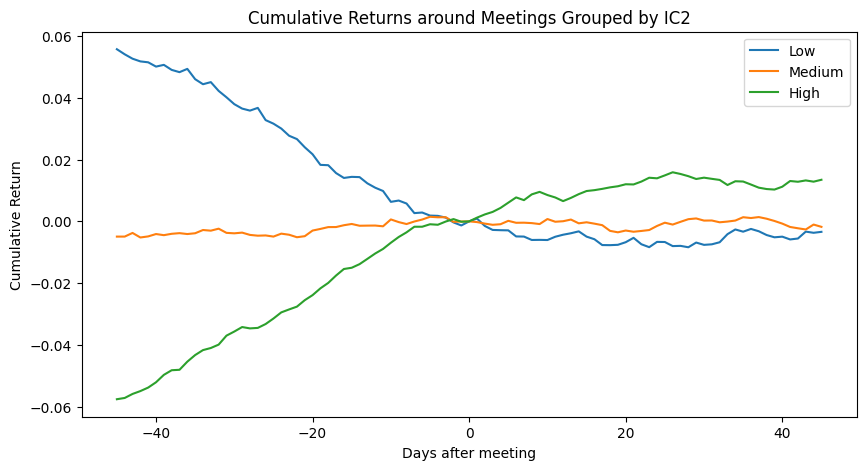

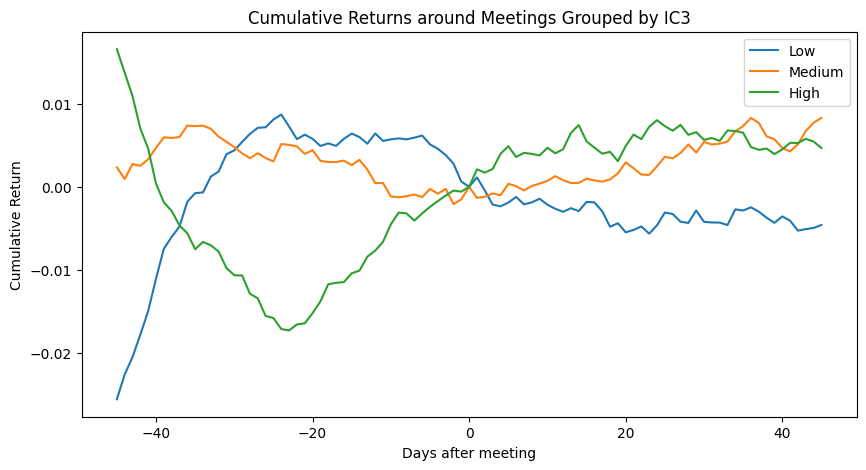

In [70]:
plot_cumulative_returns(featured_events, spts, 'IC1', title='Cumulative Returns around Meetings Grouped by IC1')
plot_cumulative_returns(featured_events, spts, 'IC2', title='Cumulative Returns around Meetings Grouped by IC2')
plot_cumulative_returns(featured_events, spts, 'IC3', title='Cumulative Returns around Meetings Grouped by IC3')

## 7. Component Loadings Over Time (PCA)

We'll now examine how the PCA component loadings have changed over time. This helps us identify periods when particular market reaction patterns were more dominant, which could be linked to different economic or policy regimes.

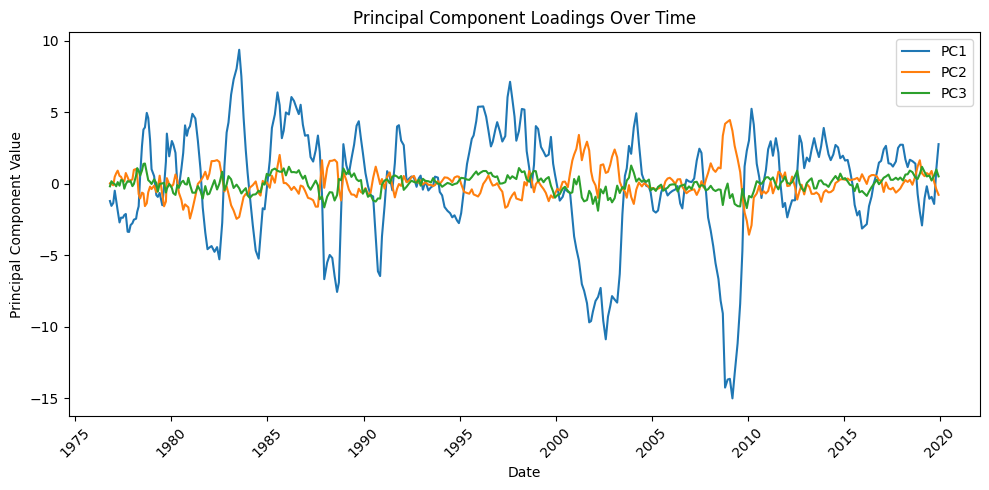

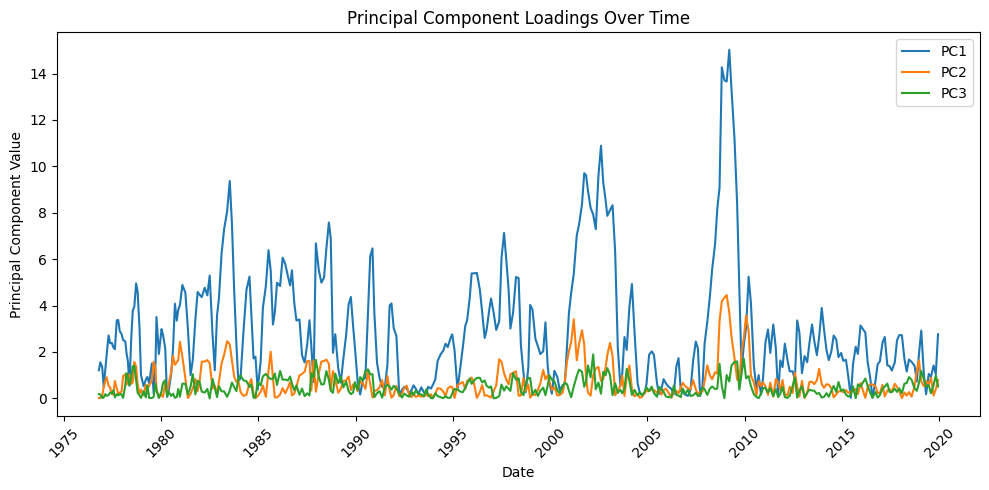

In [ ]:
#Timeseries of the PCs
plt.figure(figsize=(10, 5))
plt.plot(featured_events['Date'], featured_events['PC1'].rolling(window=8).mean(), label='PC1')
plt.plot(featured_events['Date'], featured_events['PC2'].rolling(window=8).mean(), label='PC2')
plt.plot(featured_events['Date'], featured_events['PC3'].rolling(window=8).mean(), label='PC3')
plt.title('Principal Component Loadings Over Time')
plt.xlabel('Date')
plt.ylabel('Principal Component Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Timeseries of the absolute values of the PCs
plt.figure(figsize=(10, 5))
plt.plot(featured_events['Date'], featured_events['PC1'].rolling(window=8).mean().abs(), label='PC1')
plt.plot(featured_events['Date'], featured_events['PC2'].rolling(window=8).mean().abs(), label='PC2')
plt.plot(featured_events['Date'], featured_events['PC3'].rolling(window=8).mean().abs(), label='PC3')
plt.title('Absolute Principal Component Loadings Over Time')
plt.xlabel('Date')
plt.ylabel('Principal Component Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 8. Component Loadings Over Time (ICA)

Similarly, we'll examine how the ICA component loadings have evolved over time. This reveals periods when specific independent market behaviors were more prevalent.

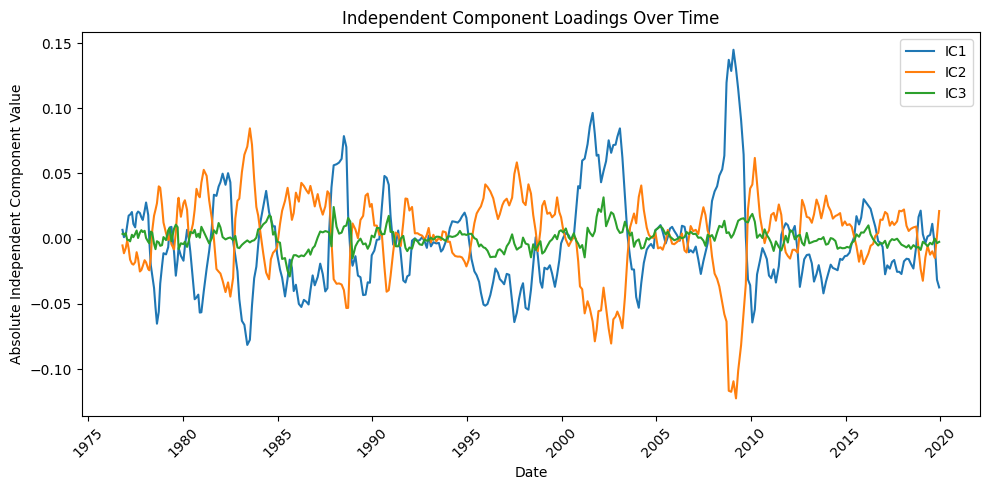

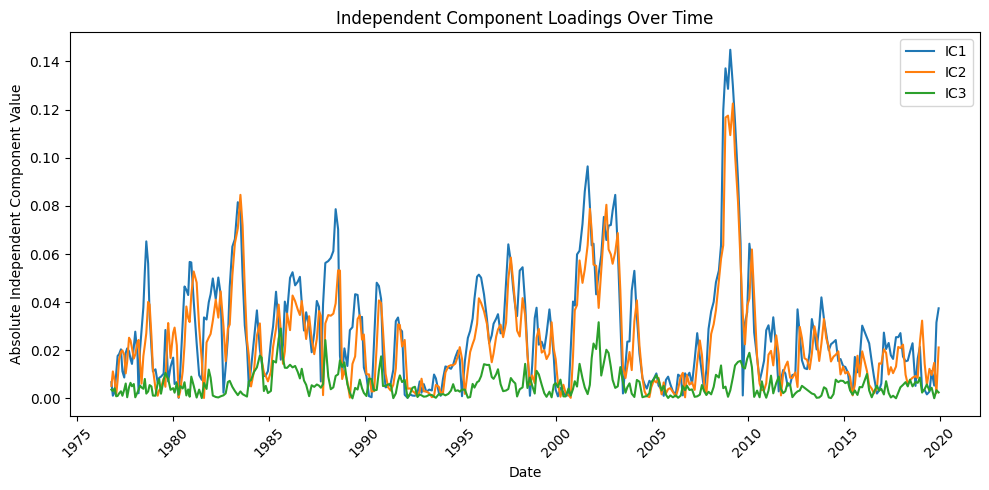

In [ ]:
# Plot ICs
plt.figure(figsize=(10, 5))
plt.plot(featured_events['Date'], featured_events['IC1'].rolling(window=8).mean(), label='IC1')
plt.plot(featured_events['Date'], featured_events['IC2'].rolling(window=8).mean(), label='IC2')
plt.plot(featured_events['Date'], featured_events['IC3'].rolling(window=8).mean(), label='IC3')
plt.title('Independent Component Loadings Over Time')
plt.xlabel('Date')
plt.ylabel('Absolute Independent Component Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Absolute ICs
plt.figure(figsize=(10, 5))
plt.plot(featured_events['Date'], featured_events['IC1'].rolling(window=8).mean().abs(), label='IC1')
plt.plot(featured_events['Date'], featured_events['IC2'].rolling(window=8).mean().abs(), label='IC2')
plt.plot(featured_events['Date'], featured_events['IC3'].rolling(window=8).mean().abs(), label='IC3')
plt.title('Absolute Independent Component Loadings Over Time')
plt.xlabel('Date')
plt.ylabel('Absolute Independent Component Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Conclusion

This analysis has identified key patterns in market reactions around FOMC meetings using both PCA and ICA. The principal components reveal the dominant modes of market behavior (by variance), while the independent components attempt to isolate truly independent market reaction patterns. The time series of component loadings further show how these patterns' prevalence has changed over different economic and policy regimes.

Further analysis could explore correlations between these components and various economic indicators or Fed policy stances to better understand what drives different market reactions.